In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

In [9]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db ='heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select* from heartdisease', con = engine)

engine.dispose()


Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

In [13]:
#divide the number of rows evenly
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
df = heartdisease_df.iloc[:rows, :]

#break into a set of features and a variable for the known outcome
X = df.iloc[:, :13]
y = df.iloc[:, 13]

#replace some random string values.
X = X.replace(to_replace = '?', value=0)

#binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y>0, 0, 1)

#Normalize
X_std = StandardScaler().fit_transform(X)

#DataFrame to store features and predicted cluster memberships
ypred = pd.DataFrame()

#create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

#split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_std, X_pca, test_size=0.5, random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.

for counter, data in enumerate([(X_half1, X_pcahalf1), 
                                (X_half2, X_pcahalf2)]):
    #put the features into ypred.
    ypred['pca_f1' + '_sample' +str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]       #what are these [1][:,1]?
    
    #generate cluster predictions and store them for clusteres 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=55).fit_predict(data[0])
        ypred['clust' +str(nclust) + '_sample' +str(counter)] = pred
    

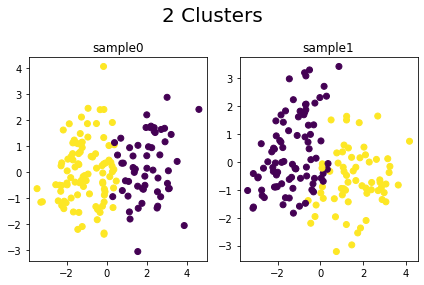

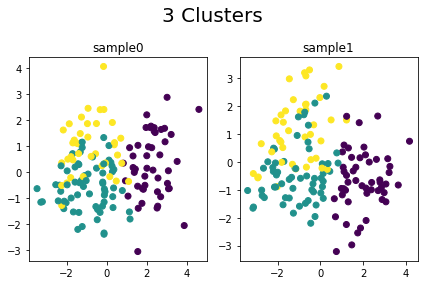

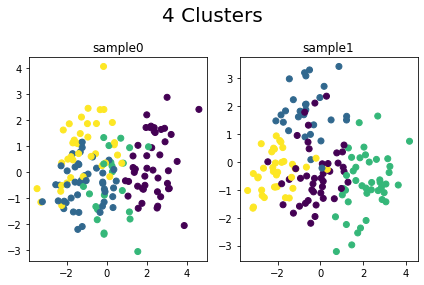

In [14]:
#for each number of clusters, plot the clusters using the pca features for each sample.

for cluster in range(2, 5):
    
    #make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    #make a plot for each sample.
    for i in range(2):
        
        #PCA-created features
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        #cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        #assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample{}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
        
    #space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [16]:
#apply k-means on the whole dataset by setting k is equal two, 
#three and four and get ARI score for each of them. Which model is the best

In [17]:
pred_2 = KMeans(n_clusters = 2, random_state=55).fit_predict(X_std)
pred_3 = KMeans(n_clusters = 3, random_state=55).fit_predict(X_std)
pred_4 = KMeans(n_clusters = 4, random_state = 55).fit_predict(X_std)

print('ARI for two cluster k-means: {}'.format(
    metrics.adjusted_rand_score(y, pred_2)))
print('ARI for three cluster k-means: {}'.format(
    metrics.adjusted_rand_score(y, pred_3)))
print('ARI for four cluster k-means: {}'.format(
    metrics.adjusted_rand_score(y, pred_4)))

ARI for two cluster k-means: 0.43661540614807665
ARI for three cluster k-means: 0.27899843718676026
ARI for four cluster k-means: 0.19321859646265876


In [18]:
#apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. 
#which model is the best?

In [19]:
pred_2 = KMeans(n_clusters=2, random_state=55).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=55).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=55).fit_predict(X_std)

print('Silhouette score for two cluster k-means: {}'.format(
    metrics.silhouette_score(X_std, pred_2, metric='euclidean')))
print('Silhouette score for three cluster k-means: {}'.format(
    metrics.silhouette_score(X_std, pred_3, metric = 'euclidean')))
print('Silhouette score for four cluster k-means: {}'.format(
    metrics.silhouette_score(X_std, pred_4, metric = 'euclidean')))

Silhouette score for two cluster k-means: 0.17440650461256255
Silhouette score for three cluster k-means: 0.12927372549232677
Silhouette score for four cluster k-means: 0.13330107899271104
